# Broadening of P($\zeta$) 

Using $    P_{new}(\zeta) = \int _0^{\infty} \text{d}\zeta_l\int _0^{\infty} \text{d}\zeta_r P(\zeta_l) P(\zeta_r) \delta(\zeta - \zeta_l - \zeta_r)$ and a finite $d\Gamma$ we show how the probability distribution evolves. For $dP=\frac{\partial P}{\partial \zeta}d\Gamma + d\Gamma P(0) P_{new} \frac{\text{d}P(\zeta)}{d\Gamma}$ we use a finite shift to the left of $d\Gamma$ instead of the first order taylor expansion and instead of $d\Gamma * P(0)$ we integrate $P$ over $[0,d\Gamma]$.

In the evolution, we renormalize the new Probability distribution: this is an action that is not required in theory because it's automatic from the equation.  In this code, however, there are numerical issues that make it slightly unprecise: as you can see by uncommenting the printing of the renormalization, it is not always 1. So we renormalize it manually.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve

In [2]:
# ---------------------------------------------------------
# 0. Classical initial probability distributions
# ---------------------------------------------------------

def exponential_P(x, lam=1.0):
    """Exponential distribution on [0,∞)."""
    return lam * np.exp(-lam * x)

def gamma_P(x, k=2, theta=1.0):
    """Gamma distribution."""
    from scipy.stats import gamma
    return gamma.pdf(x, a=k, scale=theta)

def gaussian_cut_P(x, mu=1.0, sigma=0.5):
    """Gaussian truncated to [0,∞)."""
    P = np.exp(-(x-mu)**2/(2*sigma**2))
    return np.where(x >= 0, P, 0)

def fermi_dirac_P(x, mu=1.0, T=0.2):
    """Finite-temperature Fermi-Dirac distribution on [0,∞) (numerically normalized)."""
    # Avoid overflow in exp((x - mu)/T)
    arg = (x - mu) / T
    P = 1.0 / (np.exp(arg) + 1.0)
    
    # Make sure it's zero for negative energies (if x-grid includes them)
    P = np.where(x >= 0, P, 0)
    
    # Normalize numerically
    norm = np.trapezoid(P, x)
    if norm > 0:
        P /= norm
    
    return P

# Use LaTeX-like math text
plt.rcParams.update({
    "mathtext.fontset": "cm",
    "font.size": 14,
})

In [3]:
def intelligent_xmax(x, P, p=0.99):
    dx = x[1] - x[0]
    cdf = np.cumsum(P) * dx
    cdf = np.clip(cdf, 0, 1)
    return np.interp(p, cdf, x)

In [16]:
# ---------------------------------------------------------
# 1. Set up x-grid
# ---------------------------------------------------------
x_max = 100.0                        # choose a value that takes into account how far the tail of final distribution goes
N = 50000 + 1                        # +1 to get a round dx
x = np.linspace(0, x_max, N)
dx = x[1] - x[0]

dGamma = 0.1

ratio = dGamma/dx
if (ratio < 10) or (not ratio.is_integer()):
    print("dGamma",dGamma,"must be >> dx", dx,"and the ratio must be an integer!" )

In [17]:
# ---------------------------------------------------------
# 2. define evolution step
# ---------------------------------------------------------

def shift_left(P, dx, dGamma):
    from scipy.interpolate import interp1d
    x = np.arange(len(P)) * dx
    f = interp1d(x - dGamma, P, bounds_error=False, fill_value=0)
    return f(x)

def evolve(P, x, dGamma):
    dx = x[1] - x[0]
    N = len(x)

    # -----------------------------
    # Exact left shift by dGamma
    # -----------------------------
    # shift_idx = int(dGamma / dx)
    # P_shift = np.zeros_like(P)
    # if shift_idx < N:
    #     P_shift[:-shift_idx] = P[shift_idx:]

    P_shift = shift_left(P, dx, dGamma)

    # -----------------------------
    # Correct "delta" convolution
    #  -----------------------------
    # P_conv = np.zeros_like(P)
    # for i in range(N):
    #     j_max = i + 1
    #     if j_max > 0:
    #         P_r = P[i - np.arange(j_max)]
    #         P_l = P[:j_max]
    #         P_conv[i] = np.sum(P_l * P_r) * dx

    P_conv = fftconvolve(P, P)[:N] * dx

    # # Normalize P_conv
    # integral_conv = np.trapezoid(P_conv, x)
    # if integral_conv > 0:
    #     P_conv /= integral_conv

    #print("Integral of P_conv(x):", np.trapezoid(P_conv, x))

    # -----------------------------
    # Integral of P from 0 to dGamma
    # -----------------------------
    mask = x <= dGamma
    A0 = np.trapezoid(P[mask], x[mask])
    #print("A0:",A0)

    # -----------------------------
    # Updated pdf
    # -----------------------------
    P_new = P_shift + A0 * P_conv
    P_new = np.maximum(P_new, 0)

    #print("renormalization of P_new without renormalizing", np.trapezoid(P_new, x))

    P_new /= np.trapezoid(P_new, x)

    return P_new

# Weight redistribution over each decimation step

The red area is the amount of weight lost from removing the strongest bond: it is the area lost by translating the probability distribution of $d\Gamma$ to the left. The blue area is the weight added by summing the new probability distribution. 

Normalizing by hand in the evolve function actually enforces that these two areas are the same, but even without that, in a numerically stabel code (not this one) this should be the case by construction of the evolution. This is merely a graphical depiction.

/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_61583/213383839.py:23: RuntimeWarning: overflow encountered in exp
  P = 1.0 / (np.exp(arg) + 1.0)
/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_61583/3747045107.py:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


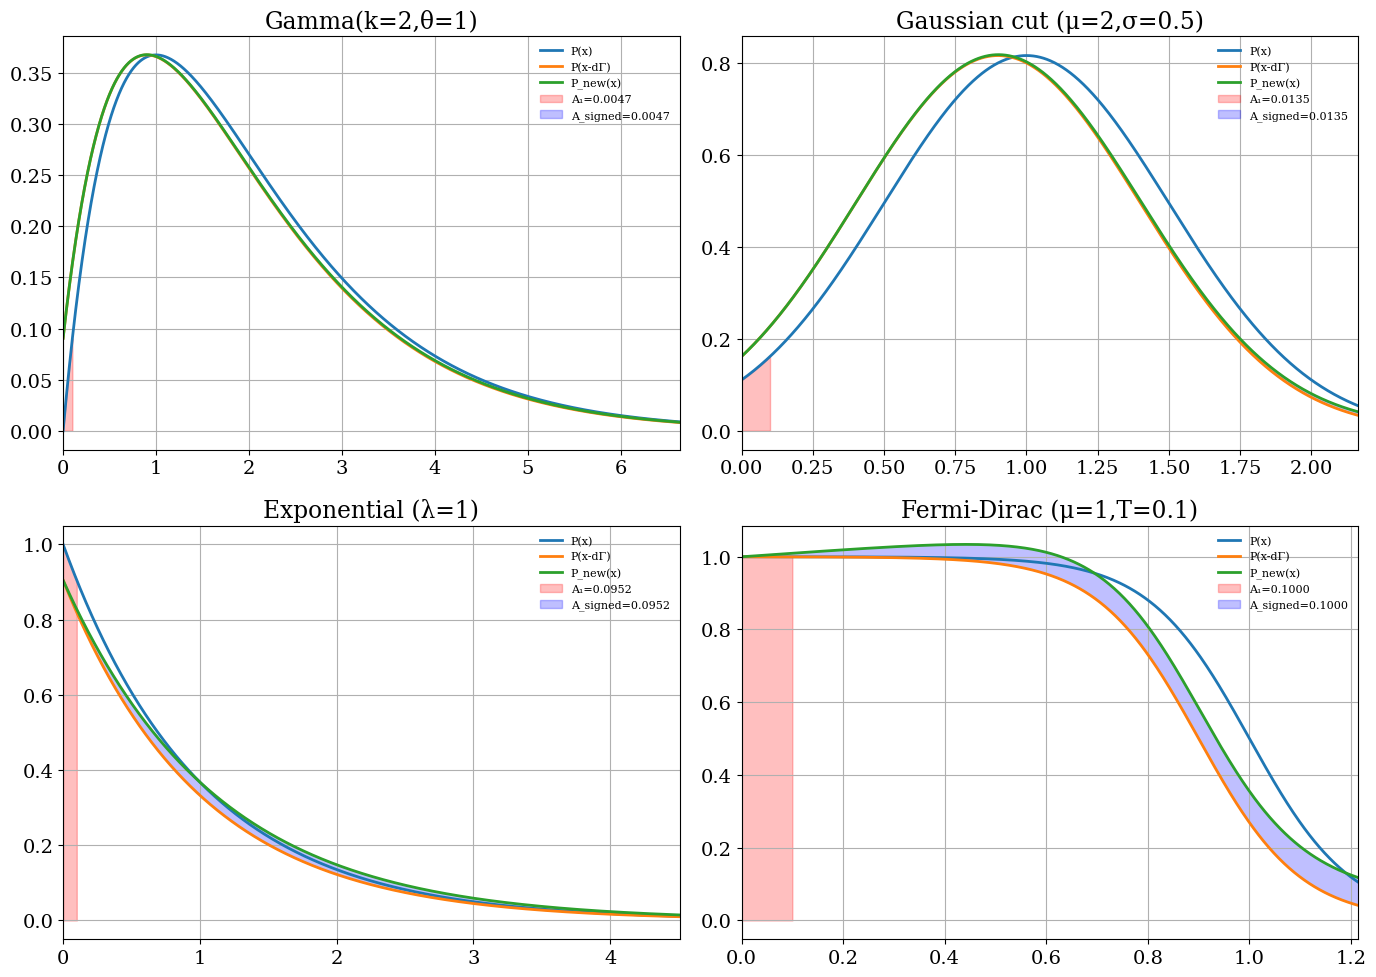

In [18]:
# ============================================
#  One plotting cell for all initial distributions
# ============================================

initial_distributions = {
    "Gamma(k=2,θ=1)": lambda x: gamma_P(x, k=2, theta=1.0),
    "Gaussian cut (μ=2,σ=0.5)": lambda x: gaussian_cut_P(x, mu=1.0, sigma=0.5),
    "Exponential (λ=1)": lambda x: exponential_P(x, lam=1.0),
    "Fermi-Dirac (μ=1,T=0.1)": lambda x: fermi_dirac_P(x, mu=1.0, T=0.1)
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, constructor) in zip(axes, initial_distributions.items()):
    # ---------------------------------------------------------
    # Build initial distribution
    # ---------------------------------------------------------
    P = constructor(x)
    P /= np.trapezoid(P, x)    

    # Evolve once
    P_new = evolve(P, x, dGamma)

    # Build shifted P(x - dGamma)
    P_shift = np.zeros_like(P)
    shift_idx = int(dGamma / dx)
    if shift_idx < len(P):
        P_shift[:-shift_idx] = P[shift_idx:]

    # Intelligent x-limit
    x_max_plot = intelligent_xmax(x, P, p=0.99)

    # ---------------------------------------------------------
    # Plot curves
    # ---------------------------------------------------------
    ax.plot(x, P, label="P(x)", linewidth=2)
    ax.plot(x, P_shift, label=f"P(x-dΓ)", linewidth=2)
    ax.plot(x, P_new, label="P_new(x)", linewidth=2)

    # ---------------------------------------------------------
    # Region 1: area under P(x) in [0, dΓ]
    # ---------------------------------------------------------
    mask_region1 = (x >= 0) & (x <= dGamma)
    area1 = np.trapezoid(P[mask_region1], x[mask_region1])
    ax.fill_between(
        x[mask_region1], P[mask_region1],
        color="red", alpha=0.25,
        label=f"A₁={area1:.4f}"
    )

    # ---------------------------------------------------------
    # Region 2: signed difference P_new - P_shift
    # ---------------------------------------------------------
    diff = P_new - P_shift
    area_signed = np.trapezoid(diff, x)

    mask_pos = diff > 0
    mask_neg = diff < 0

    # positive area
    ax.fill_between(
        x, P_shift, P_new,
        where=mask_pos,
        color="blue", alpha=0.25,
        label=f"A_signed={area_signed:.4f}"
    )
    # negative area
    ax.fill_between(
        x, P_shift, P_new,
        where=mask_neg,
        color="blue", alpha=0.25
    )

    # Formatting
    ax.set_xlim(0, x_max_plot)
    ax.set_title(name)
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


# Many steps evolution

Here we evolve a probability distribution many steps to see how it broadens and that it converges to an exponential distribution, which is the global attractor for this evolution: you can see all distribution become eventually exponential. The broadening of the exponential itself highlights the infinte disorder fixed point. 

All distributions become exponential, but which ones are valid for this decimation procedure to make sense? DOes the perturbation theory hold for all? Does the widly distributed assumption hold for all?

In [19]:
def mean_P(x, P):
    return np.trapezoid(x * P, x)

def sigma_P(x, P):
    m = mean_P(x, P)
    return np.sqrt(np.trapezoid((x - m)**2 * P, x))

def exponential_pdf(x, Gamma):
    return np.exp(-x / Gamma) / Gamma

def L1_distance(P, P_ref, x):
    return np.trapezoid(np.abs(P - P_ref), x)


/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_61583/213383839.py:23: RuntimeWarning: overflow encountered in exp
  P = 1.0 / (np.exp(arg) + 1.0)


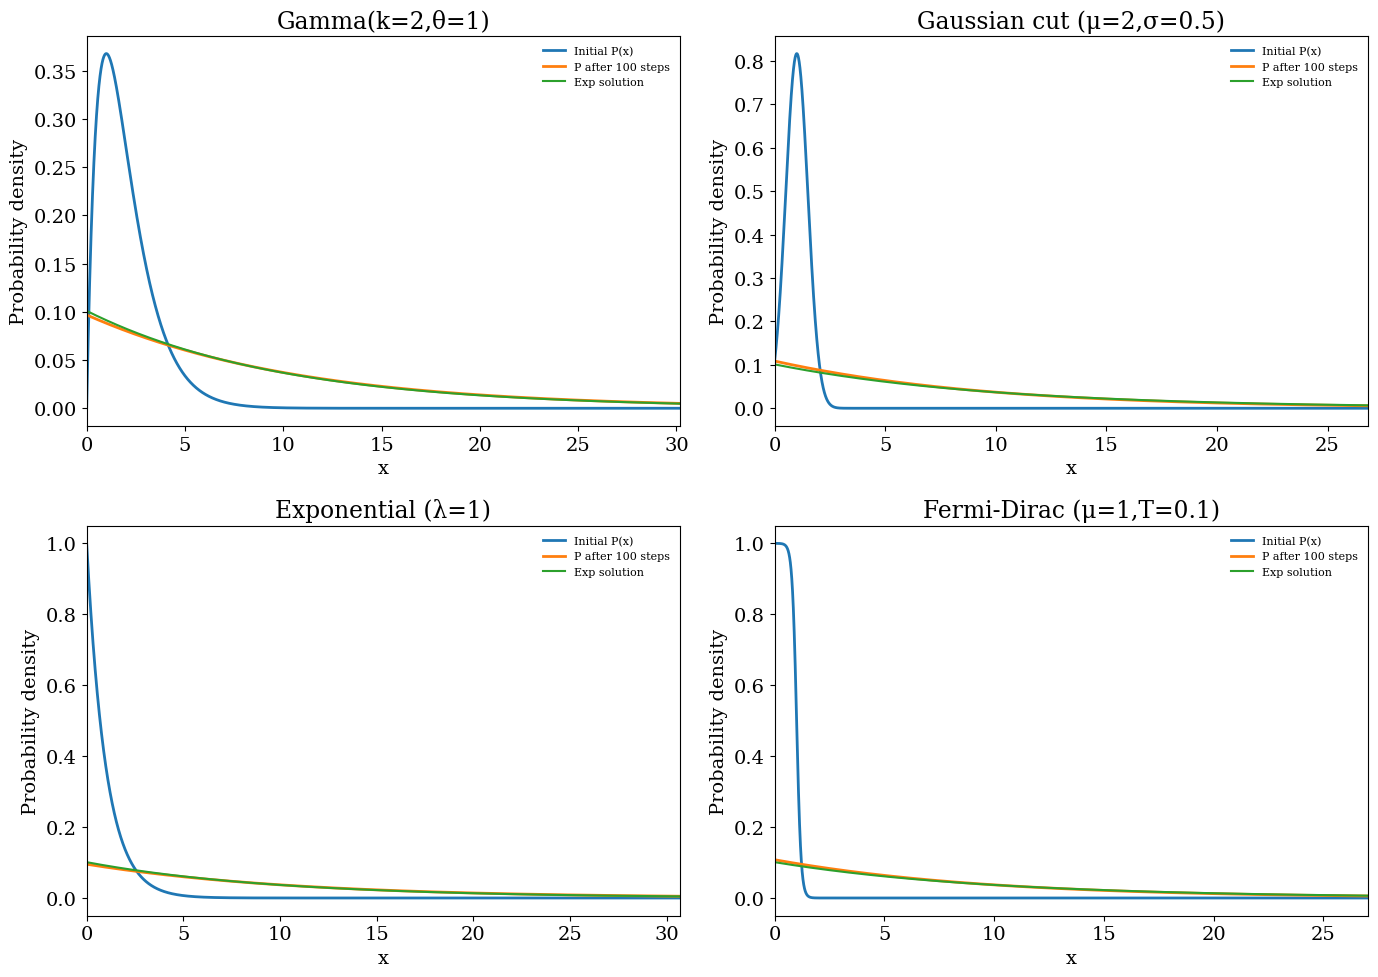

In [20]:
# ============================================
#  Evolution for all 4 initial distributions
# ============================================

n_steps = 100  # number of RG steps

initial_distributions = {
    "Gamma(k=2,θ=1)": lambda x: gamma_P(x, k=2, theta=1.0),
    "Gaussian cut (μ=2,σ=0.5)": lambda x: gaussian_cut_P(x, mu=1.0, sigma=0.5),
    "Exponential (λ=1)": lambda x: exponential_P(x, lam=1.0),
    "Fermi-Dirac (μ=1,T=0.1)": lambda x: fermi_dirac_P(x, mu=1.0, T=0.1)
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# To store diagnostics for all distributions
results = {}

for ax, (name, constructor) in zip(axes, initial_distributions.items()):

    # ---------------------------------------------------------
    # Build initial distribution
    # ---------------------------------------------------------
    P_init = constructor(x)
    P_init /= np.trapezoid(P_init, x)

    # ---------------------------------------------------------
    # Initialize storage lists
    # ---------------------------------------------------------
    Gammas = []
    Means = []
    Sigmas = []
    Errors = []

    # ---------------------------------------------------------
    # Evolve for n_steps
    # ---------------------------------------------------------
    P_current = P_init.copy()
    for step in range(n_steps):

        Gamma = step * dGamma
        Gammas.append(Gamma)

        # diagnostics BEFORE evolution step
        m = mean_P(x, P_current)
        s = sigma_P(x, P_current)
        Means.append(m)
        Sigmas.append(s)

        # exponential reference PDF
        P_ref = exponential_pdf(x, Gamma if Gamma>0 else dGamma)
        err = L1_distance(P_current, P_ref, x)
        Errors.append(err)

        # evolve one RG step
        P_current = evolve(P_current, x, dGamma)

    # save diagnostics
    results[name] = {
        "Gamma": np.array(Gammas),
        "Mean": np.array(Means),
        "Sigma": np.array(Sigmas),
        "Error": np.array(Errors)
    }

    # ---------------------------------------------------------
    # Intelligent plot cutoff (based on final PDF)
    # ---------------------------------------------------------
    x_max_plot = intelligent_xmax(x, P_current, p=0.95)

    # ---------------------------------------------------------
    # Plot
    # ---------------------------------------------------------
    ax.plot(x, P_init, label="Initial P(x)", linewidth=2)
    ax.plot(x, P_current, label=f"P after {n_steps} steps", linewidth=2)
    ax.plot(x, exponential_pdf(x, Gamma), label="Exp solution")

    ax.set_xlim(0, x_max_plot)
    ax.set_title(name)
    ax.set_xlabel("x")
    ax.set_ylabel("Probability density")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


### Standard deviation and error wrt to $\frac{1}{\Gamma}e^{-\frac{\zeta}{\Gamma}}$. 

You can see that the standard deviation diverges linearly, signaling infinite disorder. Also, the error wrt the exponential distribution, which asymptotically is the exact solution to the equation, tends to zero.

There is however an effect due to the limited support we are using for these distributions: after too many steps, the distribution tend to be too smeared on the support and becomes uniform instead of being an exponential. This numerical effect can be seen by evolving up to $\Gamma = 20$, where the errors already begin to rise and the standard deviation to flatten. 

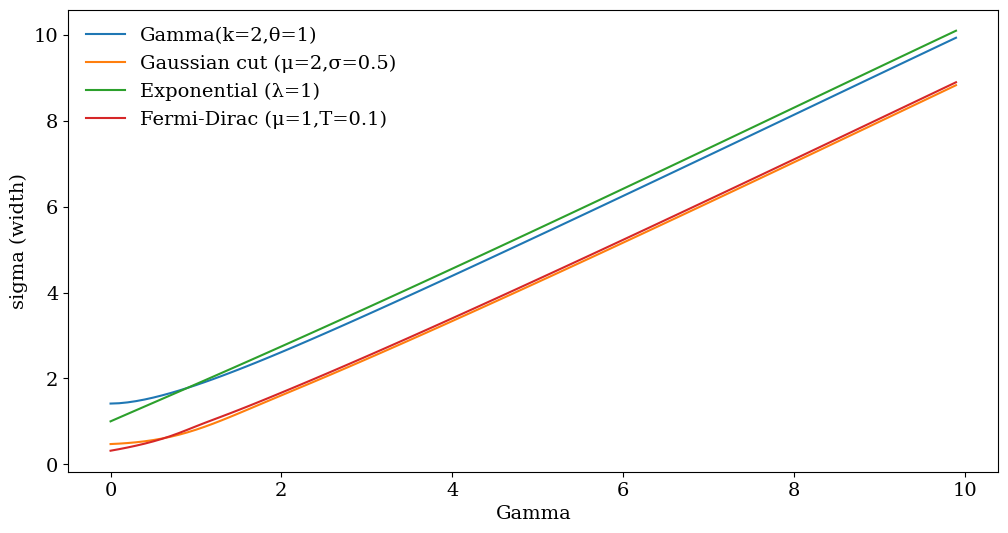

In [21]:
plt.figure(figsize=(12,6))
for name, data in results.items():
    plt.plot(data["Gamma"], data["Sigma"], label=name)
plt.xlabel("Gamma")
plt.ylabel("sigma (width)")
plt.legend()
# plt.grid()
plt.show()


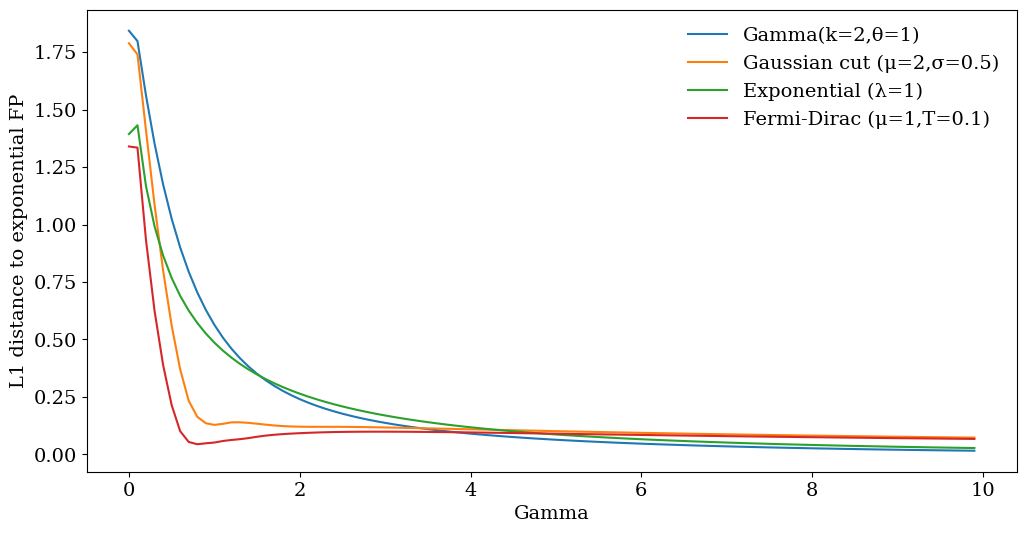

In [22]:
plt.figure(figsize=(12,6))
for name, data in results.items():
    plt.plot(data["Gamma"], data["Error"], label=name)
plt.xlabel("Gamma")
plt.ylabel("L1 distance to exponential FP")
plt.legend()
# plt.grid()
plt.show()

## GET A GIF OF THE PDF EVOLUTION: RUNNING THE FOLLOWING CELLS TAKES A LOT OF TIME

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# =====================================================
#  Animation of the RG flow for all 4 distributions
# =====================================================

# choose number of animation frames
n_frames = 100  

# dictionary of initial distributions
initial_distributions = {
    "Gamma(k=2, θ=1)": lambda x: gamma_P(x, k=2, theta=1.0),
    "Gaussian cut (μ=2, σ=0.5)": lambda x: gaussian_cut_P(x, mu=2.0, sigma=0.5),
    "Exponential (λ=1)": lambda x: exponential_P(x, lam=1.0),
    "Fermi-Dirac (μ=1, T=0.1)": lambda x: fermi_dirac_P(x, mu=1.0, T=0.1)
}

# -----------------------------------------------------
# initialize distributions for each of the 4 plots
# -----------------------------------------------------
P_list = []
P_init_list = []

for name, constructor in initial_distributions.items():
    P0 = constructor(x)
    P0 /= np.trapezoid(P0, x)
    P_list.append(P0.copy())
    P_init_list.append(P0)

# -----------------------------------------------------
# Create 2x2 figure
# -----------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

lines_init = []
lines_evol = []
titles = []

for ax, (name, P0) in zip(axes, zip(initial_distributions.keys(), P_init_list)):
    line1, = ax.plot(x, P0, label="Initial P(x)", linewidth=1.5)
    line2, = ax.plot(x, P0, label="P(x, Γ)", linewidth=2)

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 1.1 * P0.max())
    # ax.grid(True)
    ax.legend(fontsize=8)

    titles.append(ax.set_title(f"{name} — Γ = 0"))
    lines_init.append(line1)
    lines_evol.append(line2)

plt.tight_layout()


# -----------------------------------------------------
# Animation update function
# -----------------------------------------------------
def update(frame):
    global P_list

    Gamma = frame * dGamma

    for i in range(len(P_list)):
        # evolve one RG step
        P_list[i] = evolve(P_list[i], x, dGamma)

        # update evolution line
        lines_evol[i].set_ydata(P_list[i])

        # intelligent cutoff: update xlim for panel
        xmax = intelligent_xmax(x, P_list[i], p=0.99)
        axes[i].set_xlim(0, xmax)

        # update title with current Gamma
        titles[i].set_text(f"{list(initial_distributions.keys())[i]} — Γ = {Gamma:.2f}")

    return lines_evol


# -----------------------------------------------------
# Run animation
# -----------------------------------------------------
ani = FuncAnimation(fig, update, frames=n_frames, interval=100)

# Save GIF
ani.save("rg_flow.gif", writer=PillowWriter(fps=15))

plt.close(fig)

print("GIF saved as rg_flow.gif")


/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_96913/1044196639.py:23: RuntimeWarning: overflow encountered in exp
  P = 1.0 / (np.exp(arg) + 1.0)


GIF saved as rg_flow.gif


In [ ]:
# run this cell to convert the gif to a collection of images

from PIL import Image
import os

gif = Image.open("rg_flow.gif")
os.makedirs("rg_frames", exist_ok=True)

for i in range(gif.n_frames):
    gif.seek(i)
    gif.save(f"rg_frames/rg_flow_{i:03d}.png")


Plot a quantitative graph of the broadening of the distribution. What is the right thing to charactirize how broad a distribution is. 

Find a quantitative relative error with exp distribution wrt exp($\Gamma$), how fast does it converge to it.

Asymptotic exactness and infinite disorder fixed point solution. chapter 10, beta function/ bkt flow diagram

Plot everything also in real space. Standard deviation relative to the domain width $\frac{\sigma}{\Omega}$

Plot theoretical expectation of physical properties.


